Setup

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from torchvision import datasets, transforms
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal
from src.get_data import *
from src.models import *
from src.utils import *
from src.nd import *
from datetime import datetime

print(torch.version.cuda)
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

12.1
2.2.2
cuda


C:\Users\yanch\AppData\Local\Temp\ipykernel_39908\116799853.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Setting hyperparameters

In [2]:
# vary these hyparams for different models and datasets
nonlin = 'linear' # 'linear', 'Tanh', etc.

# whether we are comparing against HN & MCHN
hopfield_checking = True
# whether we are comparing with Standing (1973)'s experimental results
standing_checking = True
# Set to False if you only want to plot the experimental results by Standing (1973)
models_comparing = True

dataset = 'gaussian' # 'cifar10', 'mnist', 'tinyimagenet' or 'gaussian'
dimension = 500 # number of pixels in each image; only used for dataset = 'gaussian'
b = 0 # control the covariance between any two distinct pixels; only used for dataset = 'gaussian'
continuity = 'con' # 'con' for continuous, 'dis' for discrete; only used for dataset = 'gaussian'; set to 'con' for the paper

# sample_sizes = np.arange(start, end + interval, interval).tolist()
sample_sizes = [20, 40, 100, 200, 400, 1000, 4000, 10000]

learning_lr = 3e-4 # learning rate of PCN; 3e-4 for rPCN
learning_lrs = np.ones_like(sample_sizes) * learning_lr
li = 400 # learning iterations of PCN; 400 for rPCN
learning_iters = np.ones_like(sample_sizes) * li

print(f'sample_sizes: {sample_sizes}')
print(f'learning_lrs: {learning_lrs}')
print(f'learning_iters: {learning_iters}')

num_seeds = 5 # Set the number of seeds for the experiment; set to 5 for the paper

sample_sizes: [20, 40, 100, 200, 400, 1000, 4000, 10000]
learning_lrs: [0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003]
learning_iters: [400 400 400 400 400 400 400 400]


More setup given the hyperparameters (not necessary to understand code & results)

In [3]:
batch_sizes = [sample_size // 10 for sample_size in sample_sizes]

seeds = range(num_seeds)

prob = 0.5 + b / 2

inference_iters = 200
inference_lr = 0.1
lamb = 0

# Construct the covariance matrix from b
cov = np.ones((dimension, dimension)) * b
np.fill_diagonal(cov, 1)
# Generate the Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(cov)

#This parameter indicates whether deactivated neuron has value 0 or -1
neg = 0
set = [1, neg]

if dataset == 'mnist':
    image_size = 28
elif dataset == 'cifar10':
    image_size = 32
elif dataset == 'tinyimagenet':
    image_size = 64

corruption = 'cover' # 'cover' or 'noise'

# Set up the paths for saving the result figures
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = './models/'
if dataset == 'gaussian':
    result_path = os.path.join('./results/', f'{current_time}_rPCN_{dataset}_patterns_with_{dimension}_neurons_with_b = {b}')
else:
    result_path = os.path.join('./results/', f'{current_time}_rPCN_{dataset}')
if not os.path.exists(result_path):
    os.makedirs(result_path)

PCN_retained = sample_sizes.copy()
MCHN_retained = sample_sizes.copy()
HN_retained = sample_sizes.copy()
PCN_error_probs = np.ones_like(sample_sizes)

PCN_accuracy = np.zeros(shape=(len(sample_sizes), len(seeds)))
PCN_error_probs = np.zeros(shape=(len(sample_sizes), len(seeds)))
HN_accuracy = np.zeros(shape=(len(sample_sizes), len(seeds)))
HN_error_probs = np.zeros(shape=(len(sample_sizes), len(seeds)))
if continuity == 'con':
    MCHN_accuracy = np.zeros(shape=(len(sample_sizes), len(seeds)))
    MCHN_error_probs = np.zeros(shape=(len(sample_sizes), len(seeds)))

all_mses = np.zeros((len(sample_sizes), len(seeds)))

Main training loop

In [4]:
for k in range(len(sample_sizes)):
    sample_size, batch_size, learning_lr, learning_iter = sample_sizes[k], batch_sizes[k], learning_lrs[k], learning_iters[k]
    for ind, seed in enumerate(seeds):
        # The following chunk of code sets up the data for the experiment, including spliting data into training and testing sets
        print(f'sample size {sample_size}, seed {seed}')
        sample_size_test = sample_size
        X_data = np.zeros(shape=(sample_size, dimension))
        X_test_data = np.zeros(shape=(sample_size, dimension))
        X_HN_data = np.zeros(shape=(sample_size, dimension))
        X_test_HN_data = np.zeros(shape=(sample_size, dimension))
        if dataset == 'tinyimagenet':
            (X, _), (X_test, _) = get_tiny_imagenet('./data', 
                                                sample_size=sample_size, 
                                                sample_size_test=sample_size,
                                                batch_size=batch_size, 
                                                seed=seed, 
                                                device=device)
            size = X.shape
            print(f'size of X is {size}')
            
            flattened_size = size[-1]*size[-2]*size[-3]
            X = X.reshape(-1, flattened_size).float()
            X_test = X_test.reshape(-1, flattened_size).float()
            print(flattened_size)
        if dataset == 'cifar10':
            (X, _), (X_test, _) = get_cifar10('./data', 
                                                sample_size=sample_size, 
                                                sample_size_test=sample_size,
                                                batch_size=batch_size, 
                                                seed=seed, 
                                                device=device,
                                                binary=False,
                                                classes=None)
        
            size = X.shape
            print(f'size of X is {size}')
            
            flattened_size = size[-1]*size[-2]*size[-3]
            X = X.reshape(-1, flattened_size).float()
            X_test = X_test.reshape(-1, flattened_size).float()
            print(flattened_size)
        if dataset == 'mnist':
            (X, _), (X_test, _) = get_mnist('./data', 
                                                sample_size=sample_size, 
                                                sample_size_test=sample_size,
                                                batch_size=batch_size, 
                                                seed=seed, 
                                                device=device,
                                                binary=False,
                                                classes=None)
        
            size = X.shape
            print(f'size of X is {size}')
            
            flattened_size = size[-1]*size[-2]*size[-3]
            X = X.reshape(-1, flattened_size).float()
            X_test = X_test.reshape(-1, flattened_size).float()
            print(flattened_size)
        if dataset == 'gaussian':
            X_data = np.zeros(shape=(sample_size, dimension))
            if continuity == 'con':
                # Generate the continuous patterns with zero mean and covariance matrix calculated earlier
                for i in range(sample_size):
                    fam_pattern = np.dot(L, np.random.normal(size=(dimension,)))
                    nov_pattern = np.dot(L, np.random.normal(size=(dimension,)))
                    X_data[i] = fam_pattern
                    X_test_data[i] = nov_pattern
            if continuity == 'dis':
                template = [random.choice(set) for _ in range(dimension)]
                X_data = np.zeros(shape=(sample_size, dimension))
                X_test_data = np.zeros(shape=(sample_size, dimension))
                X_HN_data = np.zeros(shape=(sample_size, dimension))
                X_test_HN_data = np.zeros(shape=(sample_size, dimension))
                for i in range(sample_size):
                    for j in range(dimension):
                        if np.random.binomial(1, prob) == 1:
                            X_data[i][j] = template[j]
                            X_HN_data[i][j] = template[j]
                        else:
                            X_data[i][j] = abs(template[j]-1)
                            X_HN_data[i][j] = -template[j]
                        if np.random.binomial(1, prob) == 1:
                            X_test_data[i][j] = template[j]
                            X_test_HN_data[i][j] = (template[j]-1)
                        else:
                            X_test_data[i][j] = abs(template[j]-1)
                            X_test_HN_data[i][j] = (template[j]+1)
            X = torch.from_numpy(X_data).double()
            X = X.to(device)
            X_test = torch.from_numpy(X_test_data).double()
            X_test = X_test.to(device)
            size = X.shape
            print(size)
            # flattened_size = size[-1]*size[-2] # This line is needed when X and X_test are of dimension (sample_size, dimension)
            flattened_size = dimension
            X = X.type(torch.FloatTensor).to(device)
            X_test = X_test.type(torch.FloatTensor).to(device)
            print(flattened_size)
            print(X[0])

        # initialize the rPCN model
        pcn = RecPCN(flattened_size, dendrite=False, mode=nonlin).to(device)
        optimizer = torch.optim.Adam(pcn.parameters(), lr=learning_lr)

        # training rPCN
        print(f'Training for {learning_iter} epochs')
        train_mses = []
        for i in range(learning_iter):
            for batch_idx in range(0, sample_size, batch_size):
                data = X[batch_idx:batch_idx+batch_size]
                data = data.to(device)
                optimizer.zero_grad()
                pcn.learning(data)
                optimizer.step()
            train_mse = pcn.train_mse.cpu().detach().numpy()
            train_mses.append(train_mse)
            if i % 10 == 0:
                print(f'Epoch {i}, mse {train_mse}')
        # evaluate the trained rPCN model on the familiar and novel test sets, respectively
        energy_fam = pcn.energy(X).cpu().detach().numpy()
        energy_nov = pcn.energy(X_test).cpu().detach().numpy()

        # compare the rPCN's judgement against ground truth; for more details on the procedure, please refer to Appendix B in the paper
        comparison_result = compare_novelty(energy_nov, energy_fam)

        prob = 1 - comparison_result.mean()
        print(f'For sample size {sample_size}, seed {seed}, the probability of error for PCN is: {prob}')
        PCN_error_probs[k][seed] = prob

        # saving the energy historgrams of trained rPCN.
        sub_path = os.path.join(result_path, f'{sample_size}_samples_seed_{seed}')
        if not os.path.exists(sub_path):
            os.makedirs(sub_path)
        plt.figure()
        plt.hist(energy_fam, label='empirical familiar energy distribution', alpha = 0.5)
        plt.hist(energy_nov, label='empirical novel energy distribution', alpha = 0.5)
        plt.legend()
        plt.title(f'PCN energy distribution with {dimension} neurons, {sample_size} stored patterns, and b = {b}')
        plt.savefig(sub_path+'/PCN_energy_distributions', dpi=150)
        plt.close()
        
        # repeating the same procedures for HN and MCHN
        if hopfield_checking:
            energy_MCHN_fam = np.zeros(shape=(sample_size, 1))
            energy_MCHN_nov = np.zeros(shape=(sample_size, 1))
            
            for i in range(sample_size):
                energy_MCHN_fam[i] = dense_associative_energy(X[i], X, 3).cpu().detach().numpy()
                energy_MCHN_nov[i] = dense_associative_energy(X_test[i], X, 3).cpu().detach().numpy()
            
            MCHN_comparison_result = compare_novelty(energy_MCHN_nov, energy_MCHN_fam)

            MCHN_prob = 1 - MCHN_comparison_result.mean()
            print(f'For sample size {sample_size}, seed {seed}, the probability of error of MCHN is: {MCHN_prob}')
            MCHN_error_probs[k][seed] = MCHN_prob

            plt.figure()
            plt.hist(energy_MCHN_fam, label='familiar', alpha = 0.5)
            plt.hist(energy_MCHN_nov, label='novel', alpha = 0.5)
            plt.legend()
            plt.title(f'Modern Continuous Hopfield energy distribution with {dimension} neurons, {sample_size} stored patterns, and b = {b}')
            plt.savefig(sub_path+'/MCHN_energy_distributions.pdf', format = 'pdf', bbox_inches='tight')
            plt.close()
        
            energy_HN_fam = np.zeros(shape=(sample_size, 1))
            energy_HN_nov = np.zeros(shape=(sample_size, 1))
            
            for i in range(sample_size):
                energy_HN_fam[i] = hopfield_energy(X[i], X).cpu().detach().numpy()
                energy_HN_nov[i] = hopfield_energy(X_test[i], X).cpu().detach().numpy()
            
            # Note the argument order here is reversed!
            HN_comparison_result = compare_novelty(energy_HN_nov, energy_HN_fam)

            HN_prob = 1 - HN_comparison_result.mean()
            print(f'For sample size {sample_size}, seed {seed}, the probability of error of HN is: {HN_prob}')
            HN_error_probs[k][seed] = HN_prob

            plt.figure()
            plt.hist(energy_HN_fam, label='familiar', alpha = 0.5)
            plt.hist(energy_HN_nov, label='novel', alpha = 0.5)
            plt.legend()
            plt.title(f'Hopfield energy distribution with {dimension} neurons, {sample_size} stored patterns, and b = {b}')
            plt.savefig(sub_path+'/HN_energy_distributions.pdf', format = 'pdf', bbox_inches='tight')
            plt.close()


sample size 20, seed 0
torch.Size([20, 500])
500
tensor([ 9.4884e-03,  7.0018e-01,  1.2118e-01, -1.1666e+00, -4.6866e-01,
        -1.0937e+00,  4.0015e-01, -5.7055e-01,  6.1604e-01,  2.0138e+00,
         3.2624e-01,  1.4151e+00,  1.4412e-01, -2.0657e-01, -9.2910e-01,
        -6.8402e-01,  1.8167e+00,  1.3309e-02, -2.2773e-02,  2.0886e+00,
         5.7486e-01, -7.3762e-01, -1.0790e+00,  1.1446e+00,  1.3516e+00,
         1.1521e+00, -5.2948e-01,  1.2258e+00, -3.3646e-01,  8.8043e-01,
        -4.2378e-01,  9.9373e-01, -4.5802e-01,  3.8670e-01, -5.3712e-01,
         1.9883e-01,  1.0372e+00, -1.0355e+00, -1.0221e+00,  6.2403e-01,
         4.5213e-01,  7.8047e-01, -9.1377e-01, -7.2152e-01, -7.1010e-01,
        -6.8065e-01,  1.5077e-01, -2.2623e-01, -3.3718e-01,  2.7762e-02,
         8.3860e-01, -6.4429e-01,  1.6372e+00, -2.9539e-01,  2.7935e-01,
         1.2694e-02,  8.6691e-01,  7.1311e-01,  2.6456e-02,  8.3312e-01,
         9.4769e-01, -5.3776e-01,  2.4345e-01, -3.3097e-01, -2.2908e-01,
  

Calculating some statistics of the results 

In [5]:
avg_PCN_error_probs = np.mean(PCN_error_probs, axis = 1)
avg_HN_error_probs = np.mean(HN_error_probs, axis = 1)
avg_MCHN_error_probs = np.mean(MCHN_error_probs, axis = 1)
print(f'The error probabilities for different sample sizes pf PCN are {PCN_error_probs}')
print(f'The error probabilities for different sample sizes pf HN are {HN_error_probs}')
print(f'The error probabilities for different sample sizes pf MCHN are {MCHN_error_probs}')

# the following block calculate the 'number of patterns retained' by each model; for more details, please refer to Appendix B in the paper
HN_retained = sample_sizes - 2*(avg_HN_error_probs*sample_sizes) 
PCN_retained = sample_sizes - 2*(avg_PCN_error_probs*sample_sizes)
MCHN_retained = sample_sizes - 2*(avg_MCHN_error_probs*sample_sizes)
print(f'The number of patterns retained by PCN are {PCN_retained}')
print(f'The number of patterns retained by HN are {HN_retained}')
print(f'The number of patterns retained by MCHN are {MCHN_retained}')

The error probabilities for different sample sizes pf PCN are [[0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.0045  0.00425 0.0045  0.00425 0.00475]
 [0.1413  0.1364  0.1384  0.1347  0.1455 ]]
The error probabilities for different sample sizes pf HN are [[0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.      0.      0.     ]
 [0.      0.      0.001   0.      0.     ]
 [0.124   0.12325 0.11675 0.113   0.1155 ]
 [0.2867  0.3     0.3049  0.311   0.2966 ]]
The error probabilities for different sample sizes pf MCHN are [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

Plotting the top row of Fig.4 in the paper

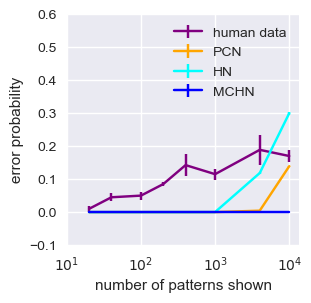

In [6]:
plt.figure(figsize=(3, 3))
log_sample_sizes = np.log10(np.array(sample_sizes))

# plotting the error probabilities from Standing (1973), "Learning 10000 pictures"
if standing_checking:
    test_trials = [20, 40, 80, 80, 80, 80, 160, 160]
    mean_errors = [0.2, 1.8, 4.0, 6.8, 11.4, 9.2, 30.2, 27.2]
    std = [0.45, 1.1, 2.2, 1.3, 5.8, 3.0, 16.4, 6.1]
    std = [a/b for a, b in zip(std, test_trials)]/np.sqrt(5) # 5 is the number subjects for normal picture in table 1 of Standing (1973)
    experimental_error_probs = [a/b for a, b in zip(mean_errors, test_trials)]
    plt.errorbar(log_sample_sizes, experimental_error_probs, yerr=std, label = 'human data', color = 'purple')
    
PCN_error_values = (np.std(PCN_error_probs, axis = 1, ddof = 1))/np.sqrt(num_seeds)
plt.errorbar(log_sample_sizes, avg_PCN_error_probs, yerr=PCN_error_values, label = 'PCN', color='orange')

HN_error_values = (np.std(HN_error_probs, axis = 1, ddof = 1))/np.sqrt(num_seeds)
plt.errorbar(log_sample_sizes, avg_HN_error_probs, yerr=HN_error_values, label = 'HN', color='cyan')

MCHN_error_values = (np.std(MCHN_error_probs, axis = 1, ddof = 1))/np.sqrt(num_seeds)
plt.errorbar(log_sample_sizes, avg_MCHN_error_probs, yerr=MCHN_error_values, label = 'MCHN', color='blue')

# Set tick labels
plt.xticks([1, 2, 3, 4], [r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
plt.ylim(-0.1, 0.6)

plt.legend()

plt.xlabel('number of patterns shown')  # Using subscript
plt.ylabel('error probability')  # Using superscript
plt.savefig(sub_path+'/plot_of_error_probs_PCN.pdf', format = 'pdf' , bbox_inches='tight')
plt.show()

Plotting the bottom row of Fig.4 in the paper

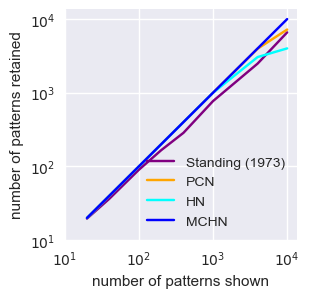

In [7]:
plt.figure(figsize=(3,3))
if standing_checking:
    experimental_retained = [19.6, 36.4, 90, 166, 286, 770, 2490, 6600]
    sample_sizes = [20, 40, 100, 200, 400, 1000, 4000, 10000]
    plt.loglog(sample_sizes, experimental_retained, label = 'Standing (1973)', color = 'purple')

if models_comparing:
    plt.loglog(sample_sizes, PCN_retained, label = 'PCN', color='orange')
    plt.loglog(sample_sizes, HN_retained, label = 'HN', color='cyan')
    plt.loglog(sample_sizes, MCHN_retained, label = 'MCHN', color='blue')
plt.legend()
plt.xlabel('number of patterns shown')  # Using subscript
plt.ylabel('number of patterns retained')  # Using superscript
plt.xticks([10**1, 10**2, 10**3, 10**4], [r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
plt.yticks([10**1, 10**2, 10**3, 10**4], [r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])

sub_path = os.path.join(result_path, f'final result')
if not os.path.exists(sub_path):
    os.makedirs(sub_path)
plt.savefig(sub_path+'/log_log_plot_percentage_of_memory_retained.pdf', format = 'pdf', bbox_inches='tight')
plt.show()